In [1]:
#jupyter notebook setup
from IPython.display import display
#supress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel

In [3]:
# Load and Summarise Dataset
df = pd.read_csv('credit.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

None

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


# 1. Exploratory Data Analysis

In [4]:
# Seperating features as categorical or numerical
categorical_features = []
numerical_features = []

for col in df.columns[:-1]:
    if df[col].dtype.char == 'O':
        categorical_features.append(col)
    else:
        numerical_features.append(col)
        
print('categorical: ',categorical_features)
print('numerical: ',numerical_features)

categorical:  ['checking_balance', 'credit_history', 'purpose', 'savings_balance', 'employment_duration', 'other_credit', 'housing', 'job', 'phone']
numerical:  ['months_loan_duration', 'amount', 'percent_of_income', 'years_at_residence', 'age', 'existing_loans_count', 'dependents']


##### 1.a. Categorical features univariate analysis

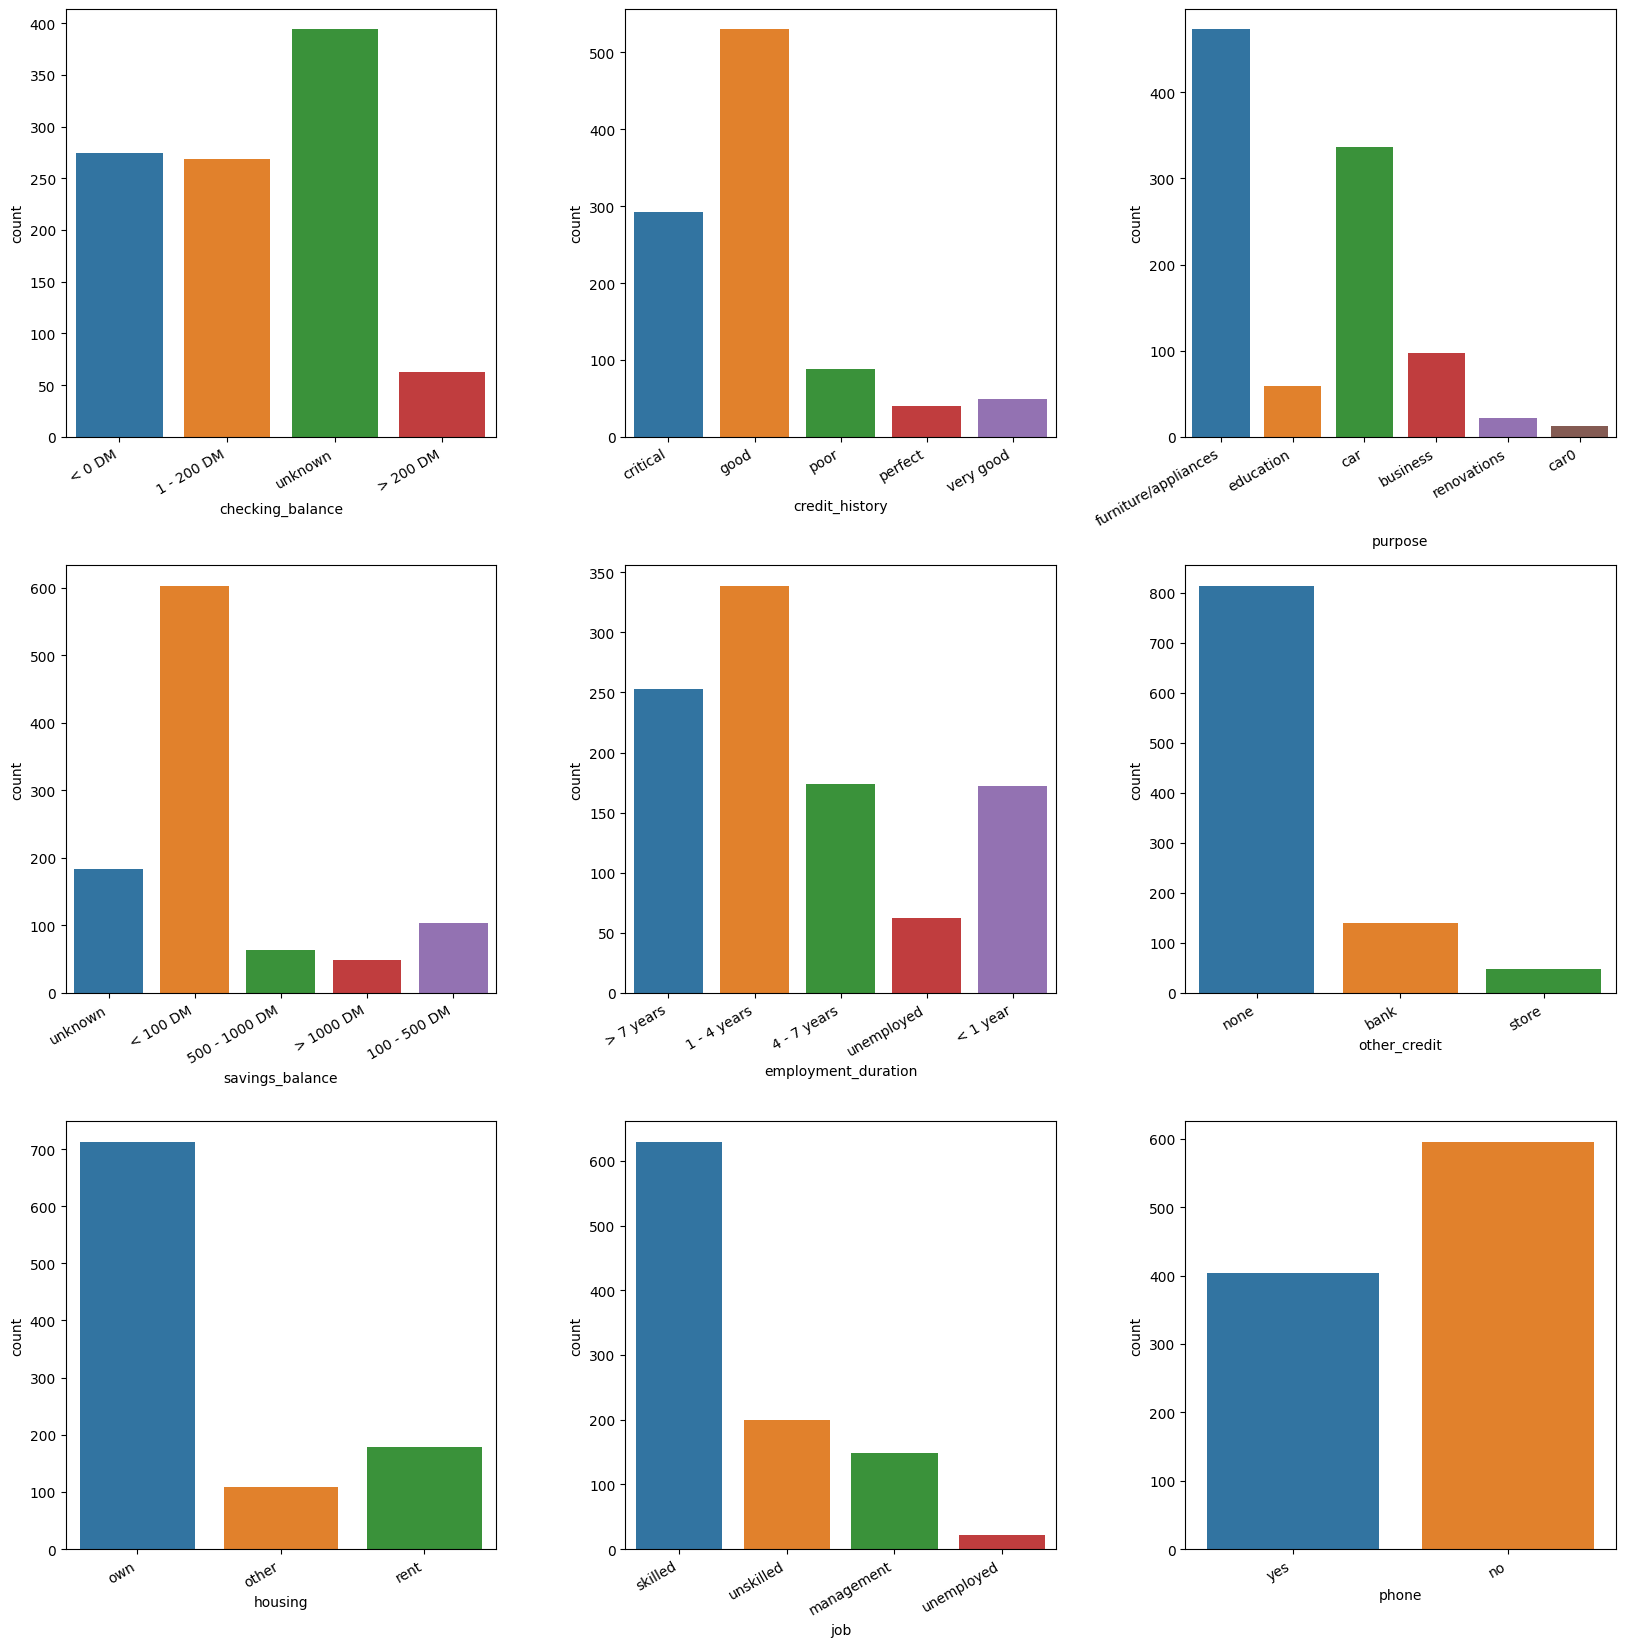

In [5]:
# Plot countplots of categorical features
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(3,3,wspace=0.3,hspace=0.3)

for ix,col in enumerate(categorical_features):
    ax=plt.subplot(grid[ix//3,ix%3])
    sns.countplot(x=col,data=df,ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

    We can see that other_credit, savings_balance and checking balance has high number of ukown/none values. We can ignore this feature in our modelling.

##### 1.b. Numerical features univariate analysis

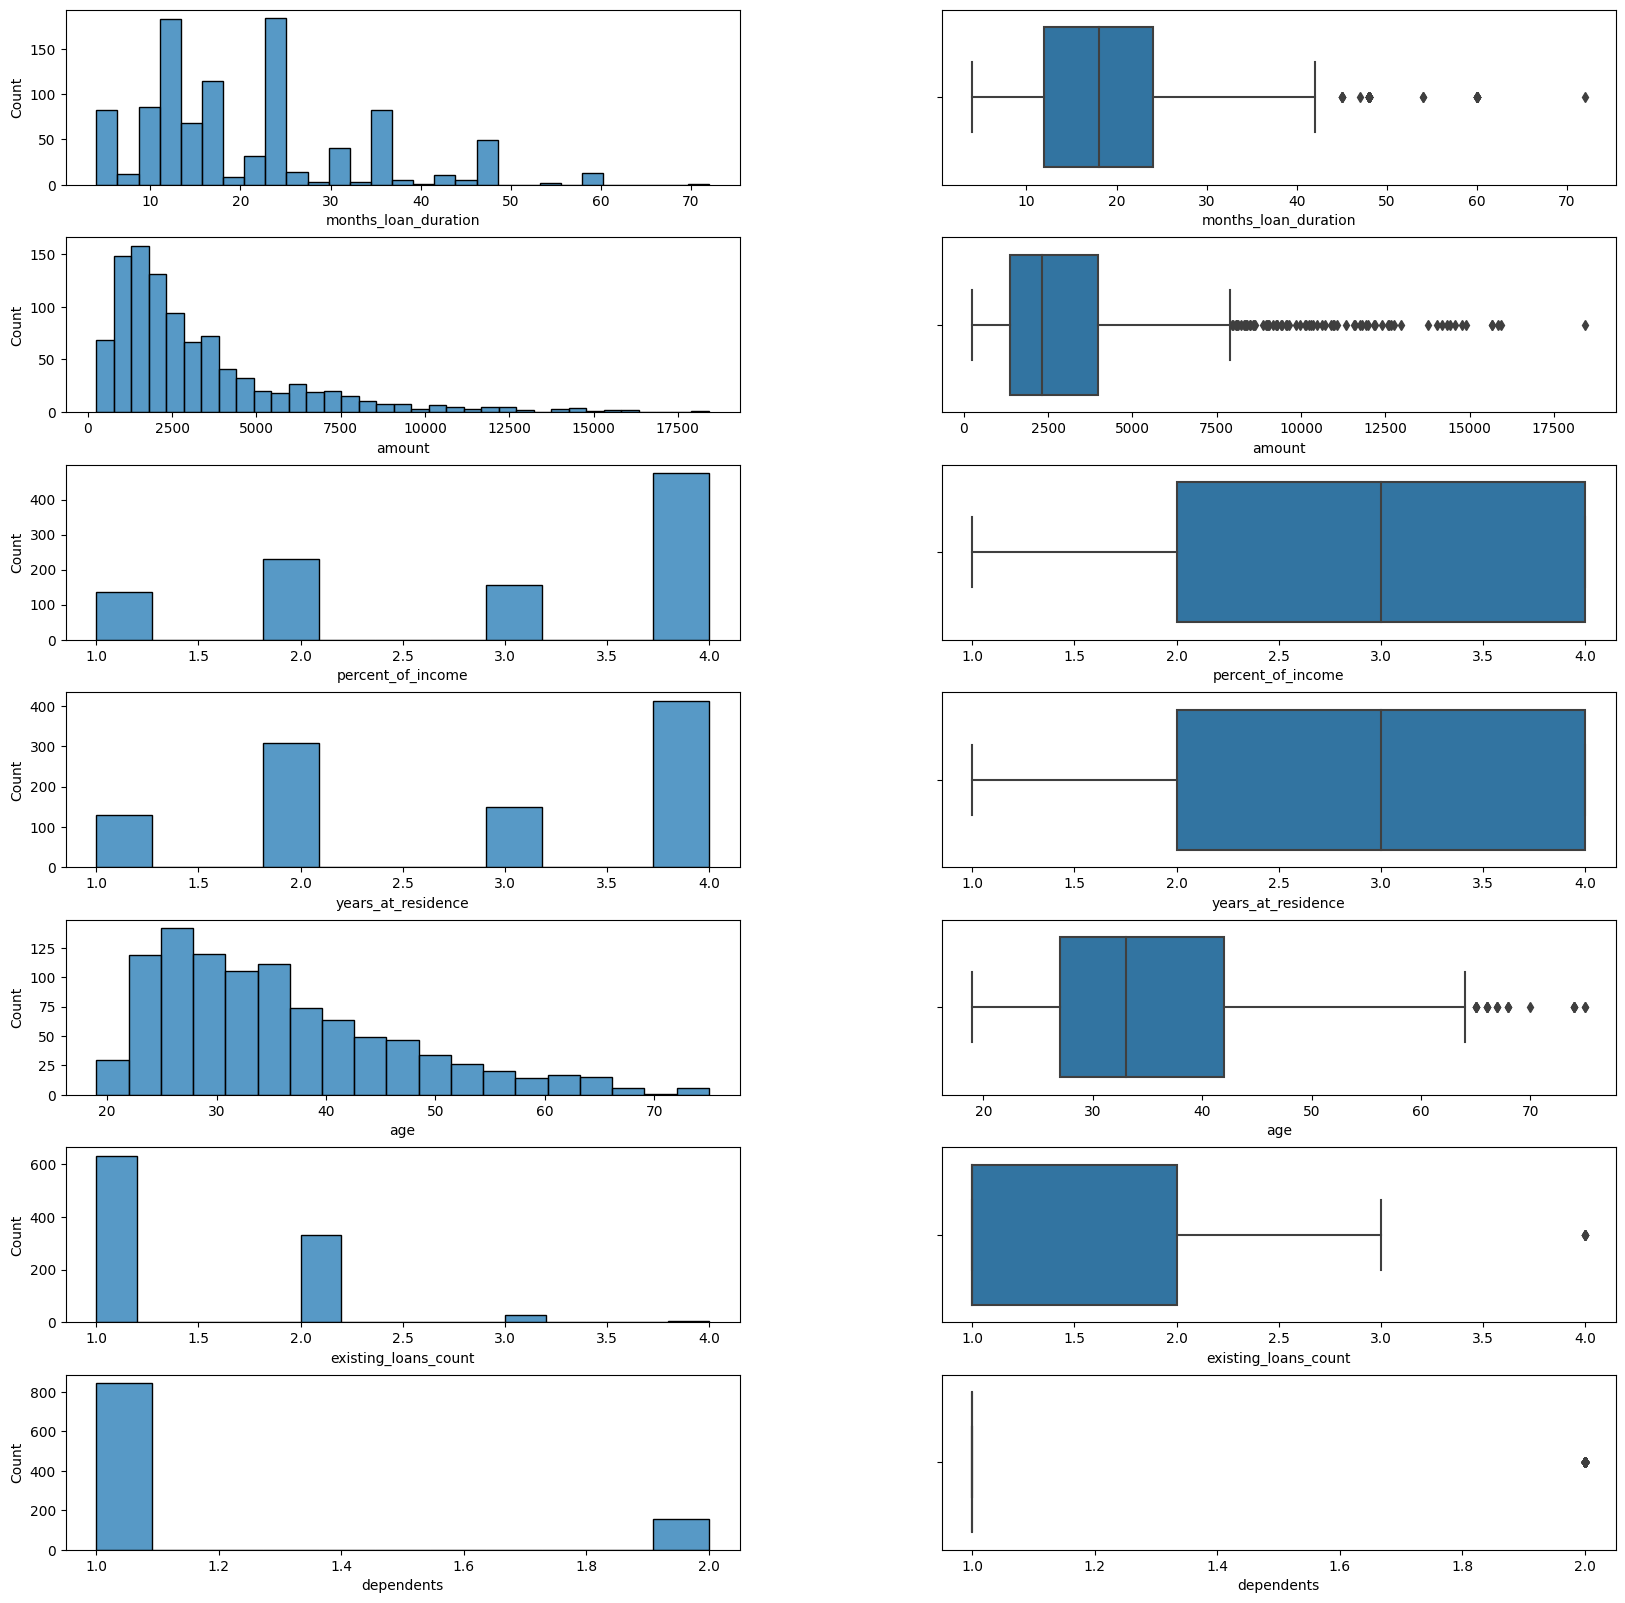

In [6]:
# Plot histplots and boxplots of numerical features
plt.figure(figsize=(20, 20))
grid = plt.GridSpec(7,2,wspace=0.3,hspace=0.3)

for ix,col in enumerate(numerical_features):
    ax=plt.subplot(grid[ix,0])
    sns.histplot(x=col,data=df)
    ax=plt.subplot(grid[ix,1])
    sns.boxplot(x=col,data=df)

    From the above charts we can see
       1. Age and Amount plot are postively skewed.
       2. There are very few loan with duration more than 40 months.
       3. Loans of amount greater than 7500 are also not common.
       4. It is not common for people with age greater than 65 to have loans.

##### 1.c Bivariate Analysis

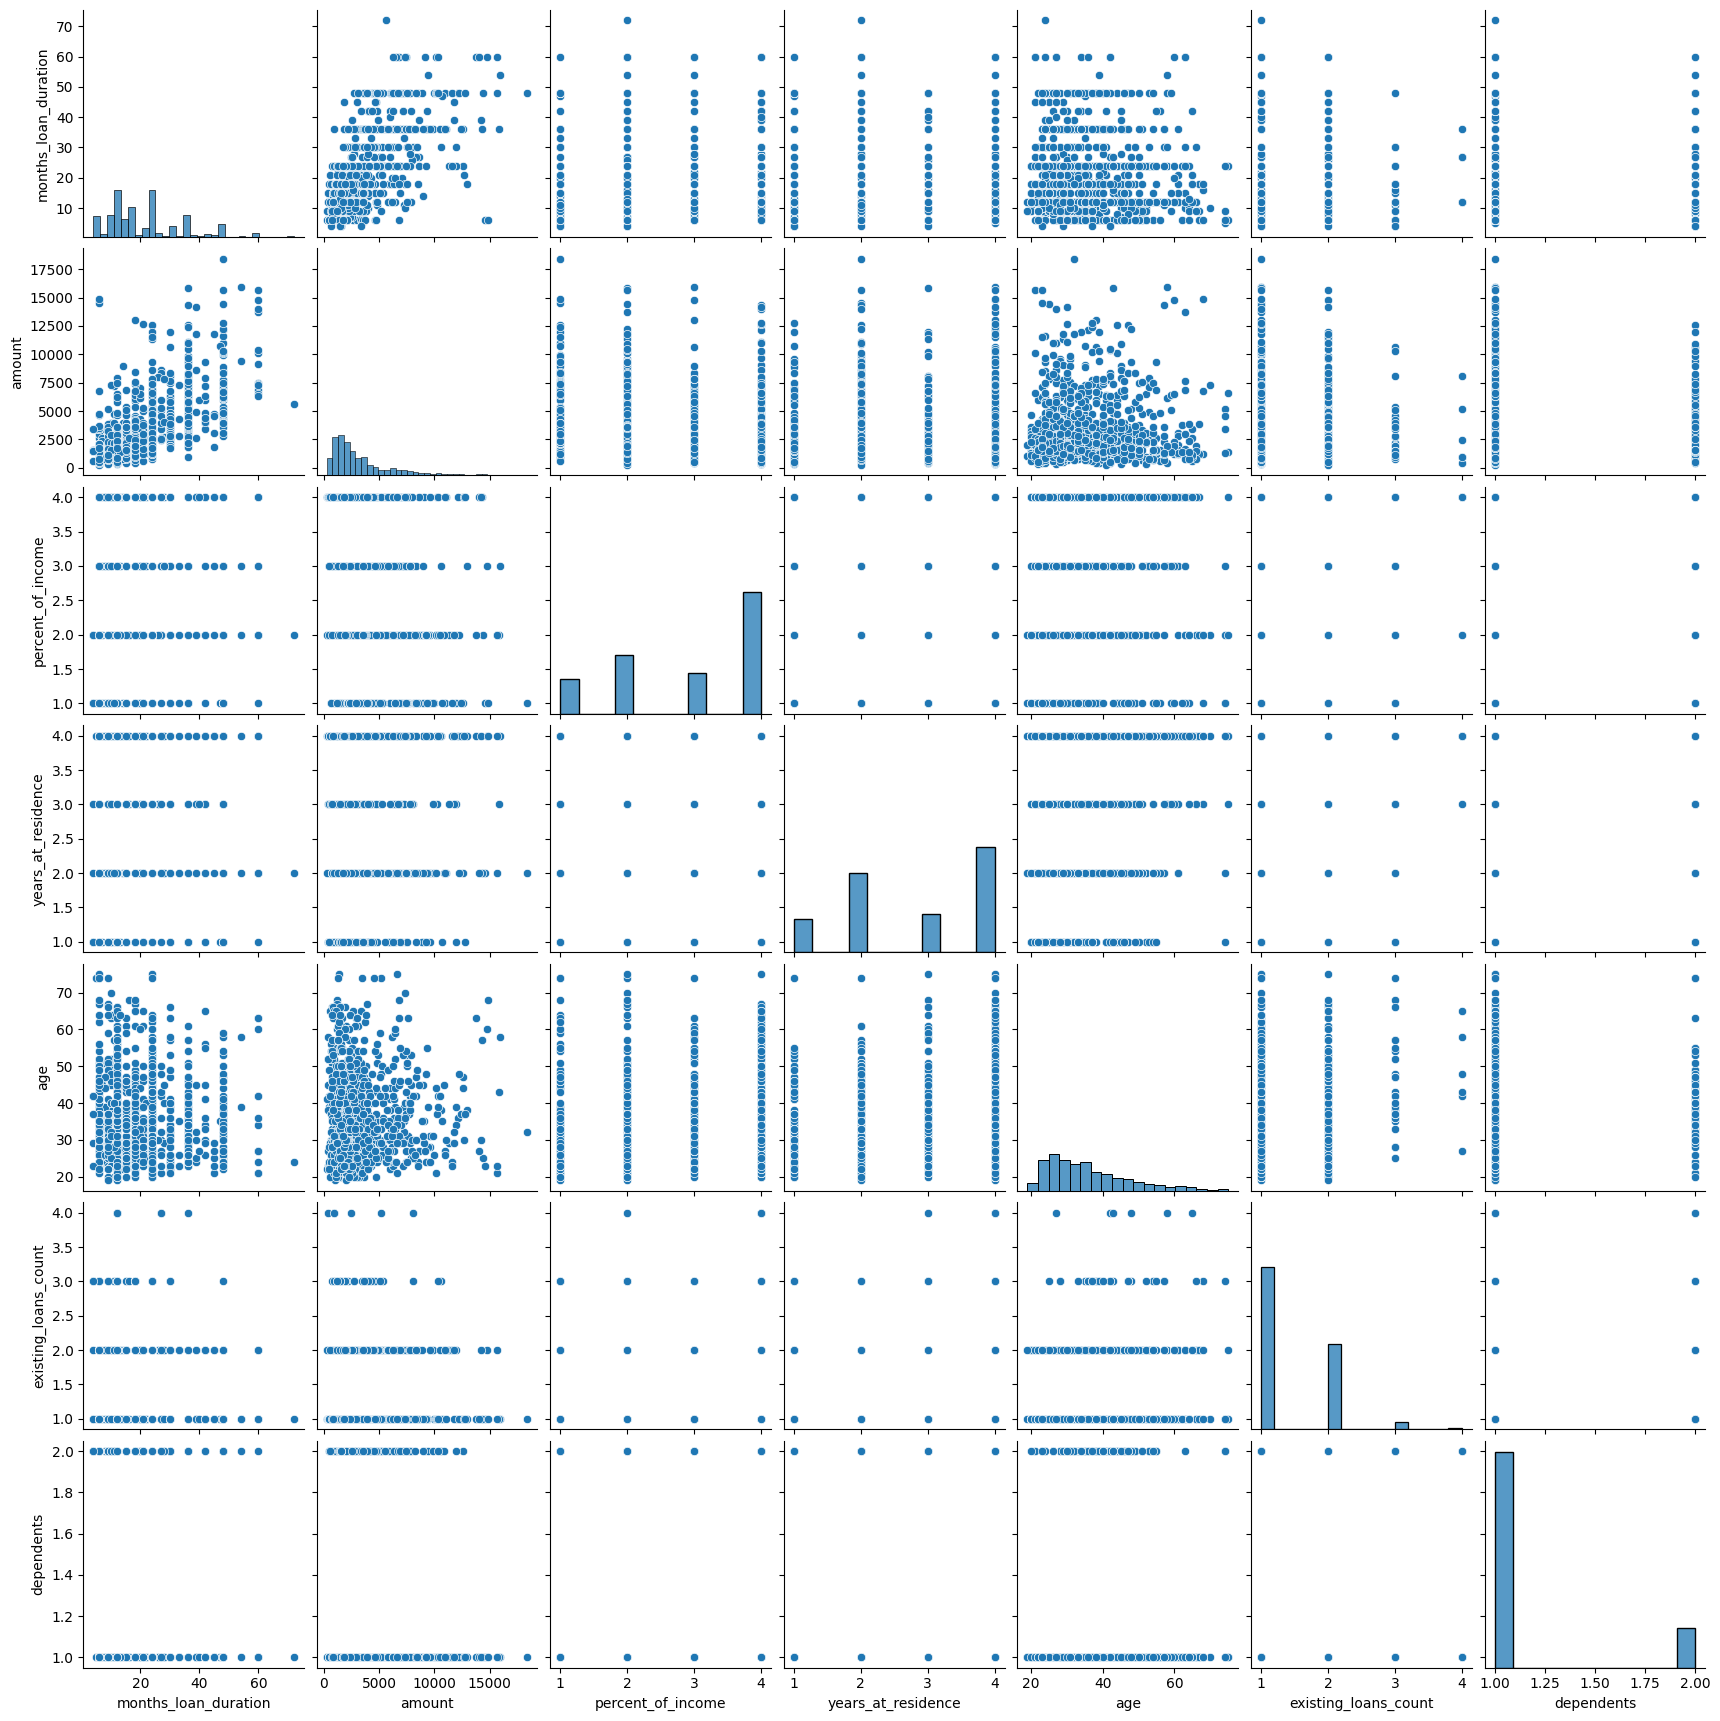

In [7]:
# Plot a pair plots
sns.pairplot(df)
plt.show()

    From the pairplot we can see there is evidence of positive relationship between month_loan_duration and amount.

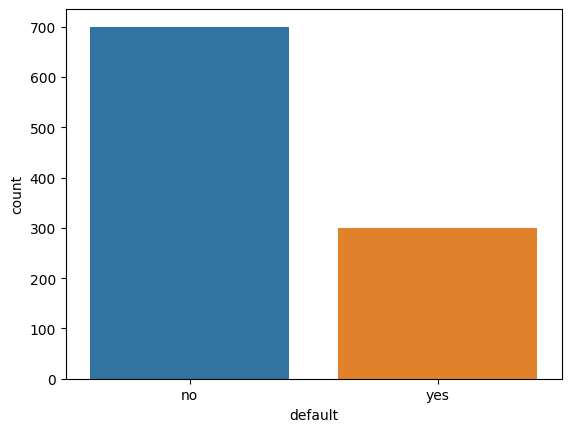

In [8]:
# Plot default and non default counts
sns.countplot(data=df,x='default')
plt.show()

    From the abnove plot we can see approximately 1/3 of the data belongs to default class and 2/3 to non-default.

##### 1.d Correlation

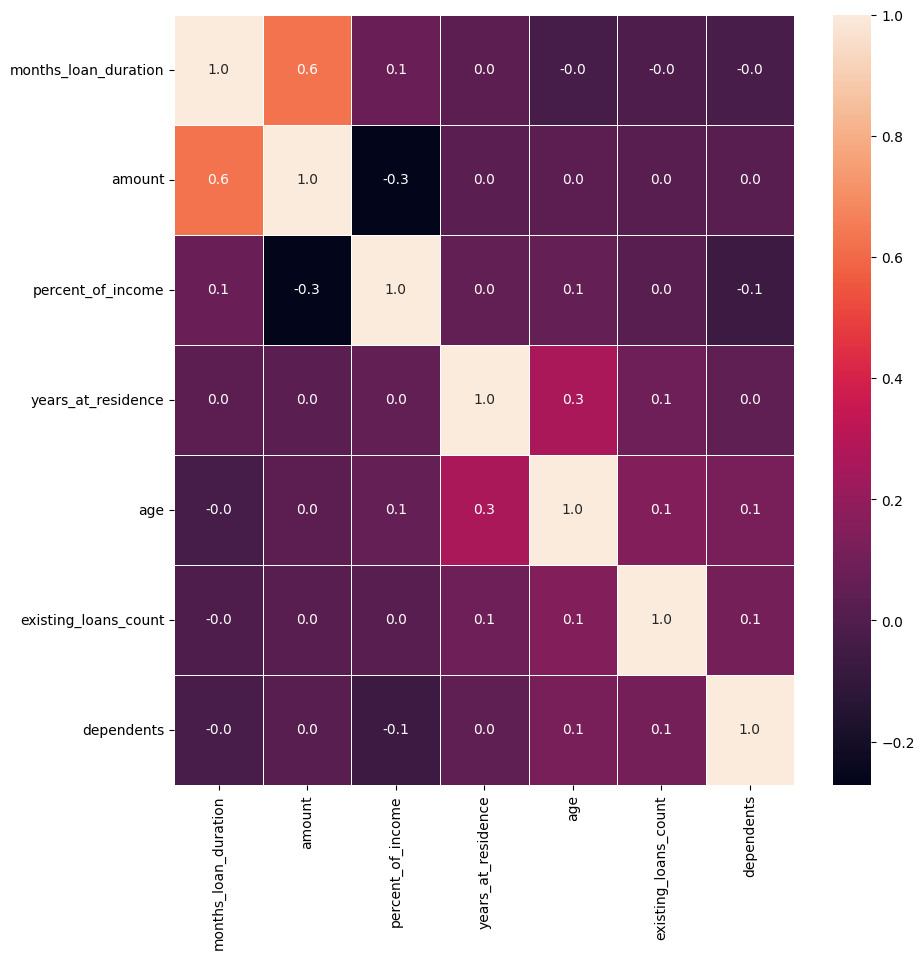

In [9]:
# Generate a Correlation Matrix
plt.figure(figsize=(10, 10))
data_correlation=df.corr(numeric_only=True)
sns.heatmap(data_correlation, annot=True, linewidths=0.5, fmt='.1f')
plt.show()

    1. We can see positive correlation between amount and month_loan_duration, which we also saw in pairplot.
    2. We can also see that there is negative correlation between amount and percent of income.

# 2. Date Preprocessing 

In [10]:
# Dropping the features with high number of unkown/none values
df.drop(['checking_balance','other_credit','savings_balance'],inplace=True,axis=1)

    We dropped the columns checking_balance, savings_balance and other_credit as they had to many missing values.

In [11]:
#Check for NA values
for col in df.columns:
    missing_values = df[col].isna().sum()
    print(col, missing_values)

months_loan_duration 0
credit_history 0
purpose 0
amount 0
employment_duration 0
percent_of_income 0
years_at_residence 0
age 0
housing 0
existing_loans_count 0
job 0
dependents 0
phone 0
default 0


    There are no missing values now, So no further deletion or imputation is needed.

In [12]:
#Creating Predictor and Response variables
Y = df['default']
X = df[df.columns.difference(['default'])]

In [13]:
#convert categorical variables to numeric
Y = Y.replace({'yes':1,'no':0})
X = pd.get_dummies(X,drop_first=True,dtype=int)

# 3. Modelling

### 3.1. Trying out diffrent models

In [14]:
#List to store results of all the tested models
model_results = []

##### 3.1.1. Logistic Regression

In [15]:
# Train and Cross Validate Logistic Regression
# Derive Mean Accuracy, Precision, Recall and F1 score
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('lr', LogisticRegression(random_state=42))])

scores = cross_validate(pipe, X, Y, scoring=['accuracy','precision','recall','f1'], cv=10)

result = {'model_name':'Logistic Regression'}
for key, value in scores.items():
    result['mean_'+key]= value.mean()
model_results.append(result)
result


{'model_name': 'Logistic Regression',
 'mean_fit_time': 0.010653471946716309,
 'mean_score_time': 0.005301237106323242,
 'mean_test_accuracy': 0.7220000000000001,
 'mean_test_precision': 0.5783229515582456,
 'mean_test_recall': 0.26666666666666666,
 'mean_test_f1': 0.3610694002196248}

##### 3.1.2. Decision Tree

In [16]:
# Train and Cross Validate Decision Tree Classifier
# Derive Mean Accuracy, Precision, Recall and F1 score
decision_tree = DecisionTreeClassifier(random_state=42)

scores = cross_validate(decision_tree, X, Y, scoring=['accuracy','precision','recall','f1'], cv=10)

result = {'model_name':'Decision Tree'}
for key, value in scores.items():
    result['mean_'+key]= value.mean()
model_results.append(result)
result


{'model_name': 'Decision Tree',
 'mean_fit_time': 0.006450867652893067,
 'mean_score_time': 0.0048004150390625,
 'mean_test_accuracy': 0.6599999999999999,
 'mean_test_precision': 0.43425742013977303,
 'mean_test_recall': 0.42000000000000004,
 'mean_test_f1': 0.4193542772946798}

##### 3.1.3. Random Forest

In [17]:
# Train and Cross Validate Random Forest Classifier
# Derive Mean Accuracy, Precision, Recall and F1 score
random_forest = RandomForestClassifier(random_state=42)

scores = cross_validate(random_forest, X, Y, scoring=['accuracy','precision','recall','f1'], cv=10)

result = {'model_name':'Random Forest'}
for key, value in scores.items():
    result['mean_'+key]= value.mean()
model_results.append(result)
result

{'model_name': 'Random Forest',
 'mean_fit_time': 0.15616099834442138,
 'mean_score_time': 0.009653043746948243,
 'mean_test_accuracy': 0.708,
 'mean_test_precision': 0.5355029435349803,
 'mean_test_recall': 0.23666666666666666,
 'mean_test_f1': 0.31713240896153205}

##### 3.1.4. Gradient Boost

In [18]:
# Train and Cross Validate Gradient Boost Classifier
# Derive Mean Accuracy, Precision, Recall and F1 score
gradient_boost = GradientBoostingClassifier(random_state=42)

scores = cross_validate(gradient_boost, X, Y, scoring=['accuracy','precision','recall','f1'], cv=10)

result = {'model_name':'Gradient Boost'}
for key, value in scores.items():
    result['mean_'+key]= value.mean()
model_results.append(result)
result

{'model_name': 'Gradient Boost',
 'mean_fit_time': 0.15273547172546387,
 'mean_score_time': 0.00550076961517334,
 'mean_test_accuracy': 0.717,
 'mean_test_precision': 0.5596757825937393,
 'mean_test_recall': 0.28333333333333327,
 'mean_test_f1': 0.37143443060563514}

##### 3.1.5. Naive Bayes

In [19]:
# Train and Cross Validate Naive Bayes Classifier
# Derive Mean Accuracy, Precision, Recall and F1 score
naive_bayes = GaussianNB()
scores = cross_validate(naive_bayes, X, Y, scoring=['accuracy','precision','recall','f1'], cv=10)

result = {'model_name':'Naive Bayes'}
for key, value in scores.items():
    result['mean_'+key]= value.mean()
model_results.append(result)
result


{'model_name': 'Naive Bayes',
 'mean_fit_time': 0.002049970626831055,
 'mean_score_time': 0.004300951957702637,
 'mean_test_accuracy': 0.7030000000000001,
 'mean_test_precision': 0.5110007974481658,
 'mean_test_recall': 0.34,
 'mean_test_f1': 0.4063907608379658}

##### 3.1.6. Aggregate Summary

In [20]:
# Combine results of the model evaluation done aboe in single dataframe
model_cv_summary_df=pd.DataFrame.from_records(model_results)
model_cv_summary_df.to_csv('model_cv_summary.csv',index=False)
model_cv_summary_df

,model_name,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,Logistic Regression,0.010653,0.005301,0.722,0.578323,0.266667,0.361069
1,Decision Tree,0.006451,0.004800,0.660,0.434257,0.420000,0.419354
2,Random Forest,0.156161,0.009653,0.708,0.535503,0.236667,0.317132
3,Gradient Boost,0.152735,0.005501,0.717,0.559676,0.283333,0.371434
4,Naive Bayes,0.002050,0.004301,0.703,0.511001,0.340000,0.406391


    1. Of all the models, decision tree has least accuracy.
    2. Logistic Regression has the highest average precision score.
    3. Random Forest and Gradient Boost are similar interms of metrics. Gradient boost has better recall and f1 score.
    4. We select Random Forest and Gradient boost to see for hyper parameter tuning to see if we can improve on accuracy.

### 3.2. Parameter Tuning

In [21]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [22]:
#Tune Ranom Forest and evaluate perfomrance metric

param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['gini', 'entropy','log_loss']
}

rf_grid_cv = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=10).fit(X_train,y_train)

random_forest = rf_grid_cv.best_estimator_

y_pred = random_forest.predict(X_test)
print('Accuracy','=',accuracy_score(y_test,y_pred))
print('Precision','=',precision_score(y_test,y_pred))
print('Recall','=',recall_score(y_test,y_pred))
print('F1_score','=',f1_score(y_test,y_pred))

Accuracy = 0.7366666666666667
Precision = 0.7727272727272727
Recall = 0.18681318681318682
F1_score = 0.3008849557522124


   Accuracy and Precision score for random forest model are improved significantly after parameter tuning.

In [23]:
#Tune Gradient Boost and evaluate perfomrance metric

param_grid = { 
    'loss': ['log_loss','exponential'],
    'n_estimators': [200, 500],
    'max_depth' : [3,4,5,6,7,8],
    'criterion' :['friedman_mse', 'squared_error']
}

rf_grid_cv = GridSearchCV(estimator=gradient_boost, param_grid=param_grid, cv=10).fit(X_train,y_train)

grad_boost = rf_grid_cv.best_estimator_

y_pred = grad_boost.predict(X_test)
print('Accuracy','=',accuracy_score(y_test,y_pred))
print('Precision','=',precision_score(y_test,y_pred))
print('Recall','=',recall_score(y_test,y_pred))
print('F1_score','=',f1_score(y_test,y_pred))

Accuracy = 0.71
Precision = 0.5370370370370371
Recall = 0.31868131868131866
F1_score = 0.4


    Accuracy score for gradient boost is improved significantly

### 3.3 Important Features

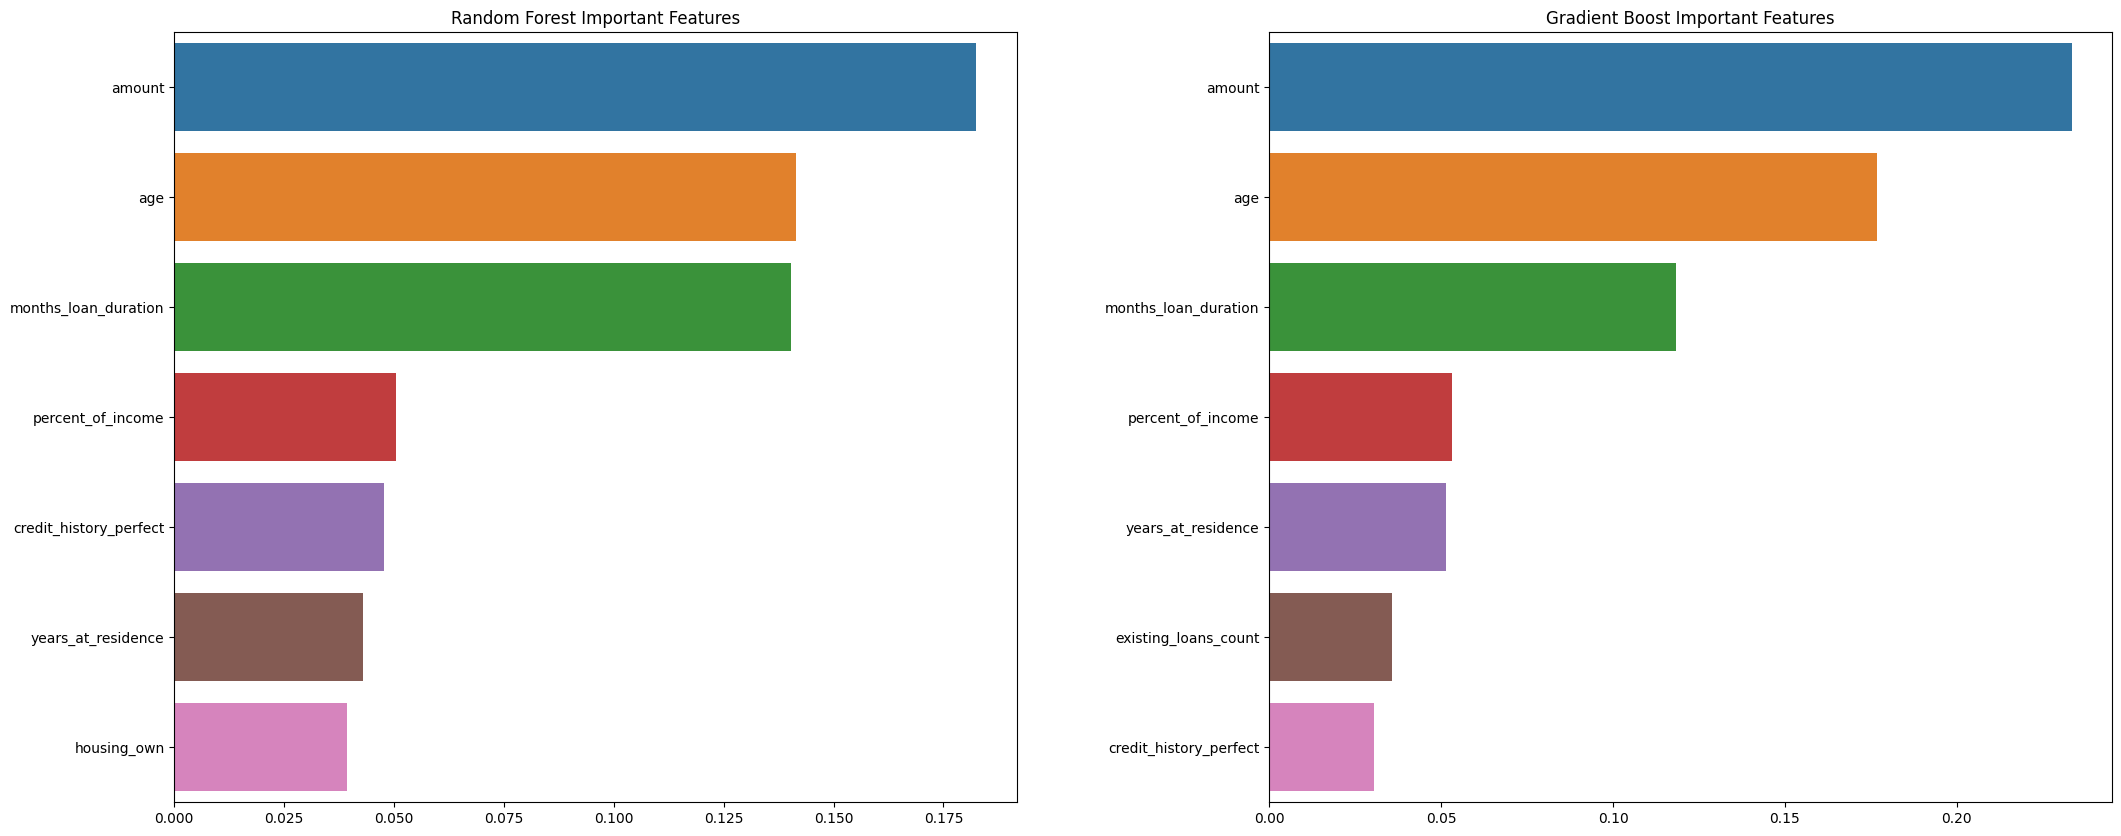

In [24]:
# Plotting top 7 features with highest improtances
random_forest_features = pd.Series(random_forest.feature_importances_,index=X.columns).nlargest(7)
grad_boost_features = pd.Series(grad_boost.feature_importances_,index=X.columns).nlargest(7)

plt.figure(figsize=(25, 10))
grid = plt.GridSpec(1,2,wspace=0.3,hspace=0.3)

ax=plt.subplot(grid[0,0])
sns.barplot(y=random_forest_features.index,x=random_forest_features.values,ax=ax)
plt.title('Random Forest Important Features')

ax=plt.subplot(grid[0,1])
sns.barplot(y=grad_boost_features.index,x=grad_boost_features.values,ax=ax)
plt.title('Gradient Boost Important Features')

plt.show()

    Amount, age and  month_loan_duration are the most important features in both random forest and gradient boost.
    Gradien boost gives prefrence to existing loan count and random forest prefers own housing.